In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures

In [28]:
# Load the data
X_train = pd.read_csv('X_train.csv')
test_df = pd.read_csv('X_test.csv')

# Step 1: Filter out post-collision data
collision_filter = (X_train['x_1'] == 0) & (X_train['y_1'] == 0) & (X_train['x_2'] == 0) & (X_train['y_2'] == 0) & (X_train['x_3'] == 0) & (X_train['y_3'] == 0)
X_train_filtered = X_train[~collision_filter]

# Step 2: Identify unique initial positions
initial_conditions = X_train_filtered[X_train_filtered['t'] == 0].copy()


###test###
# Filter initial conditions at t=0
initial_conditions_test = test_df[test_df['t'] == 0]
test_features_df = initial_conditions_test[['x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3']]

###end test###

# Create a unique identifier based on rounded initial positions
initial_conditions['trajectory_id'] = (
    initial_conditions['x_1'].round(6).astype(str) + '_' +
    initial_conditions['y_1'].round(6).astype(str) + '_' +
    initial_conditions['x_2'].round(6).astype(str) + '_' +
    initial_conditions['y_2'].round(6).astype(str) + '_' +
    initial_conditions['x_3'].round(6).astype(str) + '_' +
    initial_conditions['y_3'].round(6).astype(str)
).astype('category').cat.codes



# Map this identifier back to the main dataframe based on match at t=0
X_train_filtered = X_train_filtered.merge(initial_conditions[['trajectory_id', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']],
                                          on=['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'],
                                          how='left')

# Fill missing trajectory_ids for the rest of the times using forward fill
X_train_filtered['trajectory_id'] = X_train_filtered['trajectory_id'].ffill()

# Organize data by trajectory ID without using lambda
trajectories = {}
for trajectory_id in X_train_filtered['trajectory_id'].unique():
    trajectory_data = X_train_filtered[X_train_filtered['trajectory_id'] == trajectory_id]
    trajectory_data_sorted = trajectory_data.sort_values(by='t')
    trajectories[trajectory_id] = trajectory_data_sorted[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']].values.flatten()

In [38]:
from keras.preprocessing.sequence import pad_sequences # type: ignore

features = []
targets = []

# Iterate over each trajectory's data
for trajectory_id, positions in trajectories.items():
    # Initial conditions (first set of positions) as features
    initial_conditions = positions[:6]  # Assuming each position set (x1, y1, x2, y2, x3, y3) has 6 elements
    # All subsequent positions as targets
    subsequent_positions = positions[6:]
    
    features.append(initial_conditions)
    targets.append(subsequent_positions)

features = np.array(features)
# Assuming your data is stored as lists of arrays in 'features' and 'targets'
# Let's find the maximum length of sequences in targets for padding
max_len = max(len(t) for t in targets)

# Now pad all target sequences to have the same length
targets_padded = pad_sequences(targets, maxlen=max_len, dtype='float64', padding='post')



# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets_padded, test_size=0.2, random_state=42)


# Step 3: Create a pipeline with a scaler and linear regression model
pipeline = Pipeline([
    #('poly', PolynomialFeatures(degree=7)),  
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.7436583835424393


In [39]:
# Convert DataFrame to numpy array for consistency in scaling (StandardScaler does not require DataFrame)
test_features = test_features_df.values

# Transform features using the scaler in the pipeline
test_features_scaled = pipeline.named_steps['scaler'].transform(test_features)

# Predict the trajectories based on initial conditions
predictions = pipeline.named_steps['model'].predict(test_features_scaled)

# Ensure initial conditions are reshaped to match prediction dimensions
initial_conditions_reshaped = test_features.reshape(-1, 1, 6)  # Reshape to (N, 1, 6)

# Check dimensions of predictions to reshape appropriately
# Assuming predictions are (N, 256, 6) if model predicts 256 timesteps excluding initial conditions
if predictions.ndim == 2:
    predictions = predictions.reshape(-1, 256, 6)  # Adjust if predictions are differently shaped

# Concatenate along the time axis (axis=1)
predictions_with_initial = np.concatenate([initial_conditions_reshaped, predictions], axis=1)

# Now predictions_with_initial should be (N, 257, 6)

# Prepare data for submission
submission_data = []
for idx in range(len(predictions_with_initial)):
    for t in range(257):  # Ensuring it runs for 257 timesteps
        # Flatten the timestep data and prepend the index
        submission_data.append([idx * 257 + t] + predictions_with_initial[idx, t].tolist())

# Convert submission data into DataFrame
submission_df = pd.DataFrame(submission_data, columns=["Id", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"])

# Save the DataFrame to CSV for submission
submission_df.to_csv('baseline-model.csv', index=False)

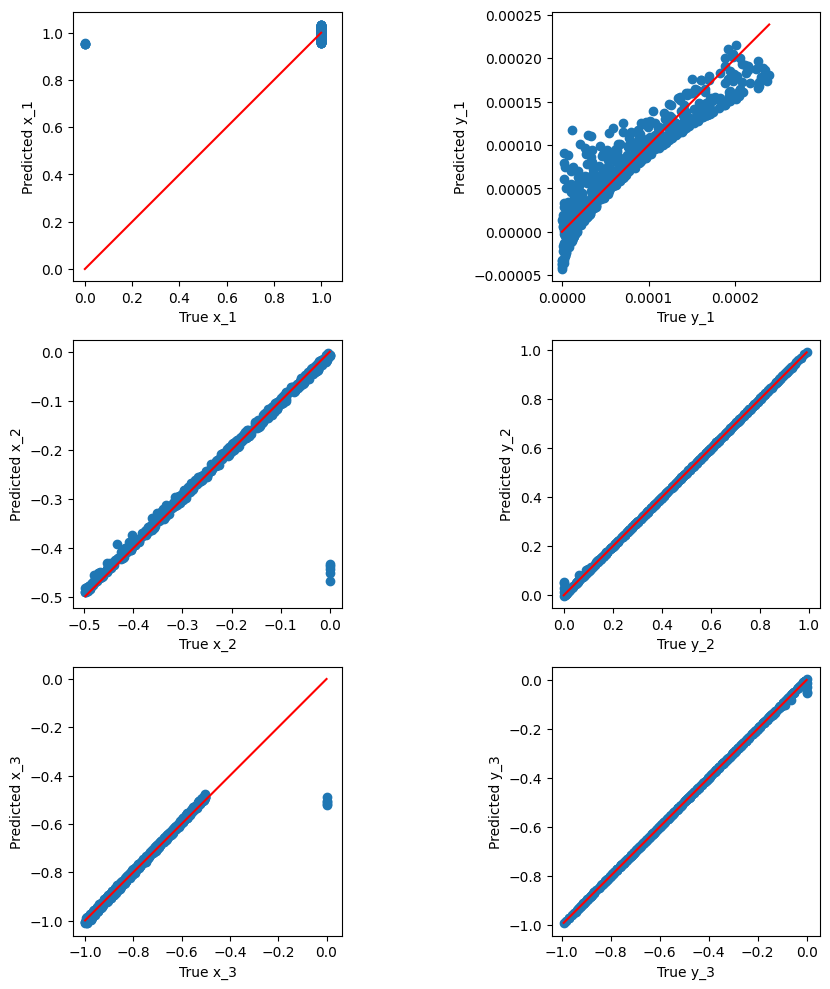

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define the plotting function
def plot_y_yhat(y_test, y_pred, plot_title="Validation Performance"):
    labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
    MAX = 500
    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test), MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10, 10))
    for i in range(6):
        x0 = np.min(y_test[idx, i])
        x1 = np.max(y_test[idx, i])
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test[idx, i], y_pred[idx, i])
        plt.xlabel('True ' + labels[i])
        plt.ylabel('Predicted ' + labels[i])
        plt.plot([x0, x1], [x0, x1], color='red')  # Identity line
        plt.axis('square')
    plt.tight_layout()  # Adjust layout to not overlap subplots
    plt.savefig(plot_title + '.pdf')
    plt.show()

# Assuming y_test and y_pred are already numpy arrays. If not, convert them.
# If they are Pandas DataFrame or Series, convert to numpy array as follows:
# y_test_array = y_test.to_numpy()
# y_pred_array = y_pred.to_numpy()

# Call the plotting function
plot_y_yhat(y_test, y_pred, "Test Set Performance")
